<img src="img/insight.svg" style="width: 300px"><br>
<font color='#544640'>
<center><i>Engineering Summit 2019</i></center>
<center><i>Denver, Colorado</i></center></font><br>
<center><i><font color='#544640' size='1'>Author: Victor Aranda</font></i></center></font>
<center><i><font color='#B81590' size='1'>victor.aranda@insight.com</font></i></center></font>
<hr>

# <font color="#D21087">Clustering & Classification</font>

<font color='#544640'>

> Cluster analysis or clustering is the task of grouping a set of objects in such a way that objects in the same group (called a cluster) are more similar (in some sense) to each other than to those in other groups (clusters). It is a main task of exploratory data mining, and a common technique for statistical data analysis, used in many fields, including machine learning, pattern recognition, image analysis, information retrieval, bioinformatics, data compression, and computer graphics.

> Cluster analysis itself is not one specific algorithm, but the general task to be solved. It can be achieved by various algorithms that differ significantly in their understanding of what constitutes a cluster and how to efficiently find them. Popular notions of clusters include groups with small distances between cluster members, dense areas of the data space, intervals or particular statistical distributions. Clustering can therefore be formulated as a multi-objective optimization problem. The appropriate clustering algorithm and parameter settings (including parameters such as the distance function to use, a density threshold or the number of expected clusters) depend on the individual data set and intended use of the results. Cluster analysis as such is not an automatic task, but an iterative process of knowledge discovery or interactive multi-objective optimization that involves trial and failure. It is often necessary to modify data preprocessing and model parameters until the result achieves the desired values.

<br>https://en.wikipedia.org/wiki/Cluster_analysis<br><br><br>


<center><img src='./img/clusters.gif' width=600 alt='KNN'></center><br><br>



<br><br><font color="#B81590">$$\large-\infty-$$</font><br><br>

In [1]:
# environment setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans

from scipy.cluster.hierarchy import linkage, dendrogram

from mpl_toolkits.mplot3d import Axes3D

<br><br><font color="#B81590">$$\large-\infty-$$</font><br><br>

### <font color="#D21087">$k$-Nearest Neighbors Clustering</font>

<font color='#544640'>

>In pattern recognition, the $k$-nearest neighbors algorithm ($k$-NN) is a non-parametric method used for classification and regression. In both cases, the input consists of the $k$ closest training examples in the feature space.

k-NN is a type of instance-based learning, or lazy learning, where the function is only approximated locally and all computation is deferred until classification. The k-NN algorithm is among the simplest of all machine learning algorithms.

<center><img src='./img/knn1.gif' width=600 alt='KNN'><br></center>

Both for classification and regression, a useful technique can be used to assign weight to the contributions of the neighbors, so that the nearer neighbors contribute more to the average than the more distant ones. For example, a common weighting scheme consists in giving each neighbor a weight of $1/d$, where $d$ is the distance to the neighbor.

The neighbors are taken from a set of objects for which the class (for $k$-NN classification) or the object property value (for $k$-NN regression) is known. This can be thought of as the training set for the algorithm, though no explicit training step is required.

https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm<br><br><br>


<center><img src='./img/knn.png' width=300 alt='k Nearest Neighbors'><br></center>



<font color='#544640'>In this example we'll be using some simulated healthcare data. The data files for training and test are named `healthcareTrain.csv` and `healthcareTest.csv`. 

Here is a brief description of the features in the data set:
1. <b>pre-rx-cost</b>: Total pharmacy costs per person
2. <b>numofgen</b>: Number of generic scripts
3. <b>numofbrand</b>: Number of brand scripts
4. <b>generic-cost</b>: Cost of generic scripts filled
5. <b>adjust-total-30d</b>: 30 day adjusted fill rate
6. <b>num-er</b>: Number of ER visits
7. <b>region</b>: US Census Region (1 = Northeast, 2 = Midwest, 3 = South, 4 = West)
8. <b>pdc-80-flag</b>: Adherent (A categorical variable that indicates if patients have adhered to taking their medications more than 80% of the time; = 1 if pdc ≥ 0.80; = 0 otherwise)

We will be using the following features to train our model:
* pre_rx_cost<br>
<li>numofgen<br>
<li>numofbrand<br>
<li>generic-cost<br>
<li>adjust_total_30d<br>
<li>num_er<br>

</font>

In [7]:
train_df = pd.read_csv('./data/healthcare_train.csv', index_col=0)
test_df = pd.read_csv('./data/healthcare_test.csv', index_col=0)

In [11]:
# we will need this helper function
def normalize(a, b):
    r"""
    This does not really handle bad parameters - expects Pandas Series for both a and b
    a : 'target' DF which includes the specific values we want to normalize
    b : the 'master' DF which includes all possible values in the space (including a)
    """
    return ([(a.iloc[i] - b.min()) / (b.max() - b.min())
             for i in range(len(a))])

In [12]:
feature_list = [
    'pre_rx_cost', 'numofgen', 'numofbrand', 'generic_cost',
    'adjust_total_30d', 'num_er'
]

# training data
input_train_labels = train_df[['pdc_80_flag']]
input_train_features = train_df[feature_list]

# testing data
input_test_labels = test_df[['pdc_80_flag']]
input_test_features = test_df[feature_list]

<font color='#544640'>We need to normalize our data. Normalizing is an important step for KNN (and in many other cases) because it prevents one field from overwhelming the others. For example, if one feature's values rang from 0.002 to 0.006 (i.e. some delicate measurement) awhereas another feature's values range from 800 to 1600, we cannot weight them equally when calculating our KNN algorithm.

Normalizing (in this case) is taking the features (columns) and re-scaling them equally, for example squeezing the minimum to be 0 and the maximum to be 1, and redistributing all of the data in between that range for each feature. The proportion between the data points in each feature is preserved, which is what matters.<br><br>

https://en.wikipedia.org/wiki/Normalization_(statistics)

There is a bit of a trick here- we have to combine our ***test data*** and our ***train data*** and normalize them together. Otherwise our training data set will potentially be scaled incorrectly.</font>

In [13]:
input_train_features_norm = input_train_features.copy()
input_test_features_norm = input_test_features.copy()

merge = [input_train_features, input_test_features]

# use this merged df as a basis for the span of values in each column
merge_df = pd.concat(merge)

for col in range(input_train_features_norm.shape[1]):
    # normalize each column of train values
    input_train_features_norm.iloc[:, col] = normalize(
        input_train_features.iloc[:, col], merge_df.iloc[:, col])

    # normalize each column of test values
    input_test_features_norm.iloc[:, col] = normalize(
        input_test_features.iloc[:, col], merge_df.iloc[:, col])

<font color='#544640'>Let's build our model. We are going to step through a variety of $k$ values and figure out which $k$ provides the best overall accuracy (this is the ***training*** phase).</font>

In [25]:
# preparing variables
# you can change the two k values if you want!

k_init = 75
k_max = 105

k_stepsize = 2
n_steps = int((k_max - k_init) / k_stepsize + 1)
k_values = [k_init + i * k_stepsize for i in range(n_steps)]

n_predictions = input_test_features_norm.shape[0]

predictions = np.zeros([n_steps, n_predictions])

# set initial value of predicted PDC80 to -1, an invalid value
predictions[:] = -1

In [26]:
# knn model

for i in range(n_steps):
    k = i * k_stepsize + k_init
    model = KNeighborsClassifier(
        n_neighbors=k, weights='uniform', p=2, metric='minkowski')
    model.fit(input_train_features_norm, input_train_labels.values.ravel())

    # store predictions for this k
    predictions[i, :] = model.predict(input_test_features_norm)

<font color='#544640'>Now we can evaluate our model. This is the ***testing*** phase.</font>

In [27]:
# evaluate our success rate

prediction_rate = np.zeros([n_steps])

for i in range(n_steps):
    prediction_rate[i] = sum([
        predictions[i, j] == input_test_labels.iloc[j]
        for j in range(n_predictions)
    ]) / n_predictions

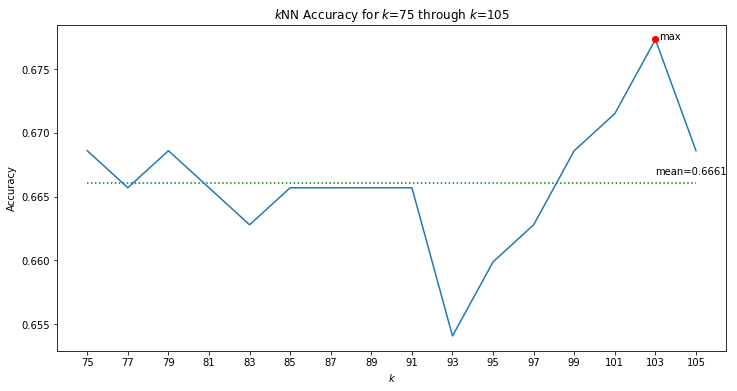

In [28]:
%matplotlib inline

plt.subplots(1, 1, figsize=(12, 6))

plt.plot(prediction_rate)
plt.title('$k$NN Accuracy for $k$=' + str(k_init) + ' through $k$=' + str(k_max))
plt.xticks(np.arange(n_steps), k_values)
plt.xlabel('$k$')
plt.plot(13.985, .67733, 'ro')
plt.hlines(y=np.mean(prediction_rate), xmin=0, xmax=n_steps-1, linestyles=':', colors='green')
plt.text(14.1, .67733, 'max')
plt.text(14, np.mean(prediction_rate)*1.001, 'mean='+str(round(np.mean(prediction_rate),4)))
plt.ylabel('Accuracy')

plt.show()

<font color='#544640'>The values for $k$ which produced the best results was $k = 103$, with an accuracy of 67.73%.</font>

<br><br><font color="#B81590">$$\large-\infty-$$</font><br><br>

### <font color="#D21087">$k$-Means Clustering</font>

<font color='#544640'>

>$k$-means clustering is a method of vector quantization, originally from signal processing, that is popular for cluster analysis in data mining. $k$-means clustering aims to partition n observations into $k$ clusters in which each observation belongs to the cluster with the nearest mean, serving as a prototype of the cluster. This results in a partitioning of the data space into ***Voronoi cells***.

https://en.wikipedia.org/wiki/K-means_clustering<br><br><br>


<center><img src='./img/kmeans1.gif' width=600 alt='K-Means><br></center>

<center><img src='./img/kmeans2.gif' width=600 alt='K-Means'><br></center>

> In mathematics, a Voronoi diagram is a partitioning of a plane into regions based on distance to points in a specific subset of the plane. That set of points (called seeds, sites, or generators) is specified beforehand, and for each seed there is a corresponding region consisting of all points closer to that seed than to any other. These regions are called Voronoi cells.<br> 
> <br>In the simplest case, shown in the first picture, we are given a finite set of points $\{~p_1,~\ldots,~p_n\}$ in the Euclidean plane. In this case each site pk is simply a point, and its corresponding Voronoi cell $R_k$ consists of every point in the Euclidean plane whose distance to $p_k$ is less than or equal to its distance to any other $p_k$. Each such cell is obtained from the intersection of half-spaces, and hence it is a convex polygon. The line segments of the Voronoi diagram are all the points in the plane that are equidistant to the two nearest sites. The Voronoi vertices (nodes) are the points equidistant to three (or more) sites.

https://en.wikipedia.org/wiki/Voronoi_diagram<br><br>

An example of a Voronoi Diagram:<br><br>

<center><img src='./img/voronoi.png' width=300 alt='Voronoi Diagram'><br></center>

<center><font size=1>By <a href='https://commons.wikimedia.org/w/index.php?curid=38534275'>Balu Ertl - Own work</a>, CC BY-SA 4.0 </font></center><br><br>

We use $k$-means for clustering in this example, but in other cases this algorithm can help with feature learning and signal processing.

<font color='#544640'></font>

<font color='#544640'>Say we have a set of data regarding visitors to our website and we'd like to classify them by their behavior. We could know which pages they visit when, for example, how long they stay on the site, how frequently they visit, etc.</font>

In [29]:
visitors_df = pd.read_csv('./data/visitors.csv', index_col = 0)
#visitors_df

<font color='#544640'>For this example we have three dimensions. Conveniently, we also live in and observe the world in three dimensions, so we can do a pretty fancy plot.</font>

<IPython.core.display.Javascript object>


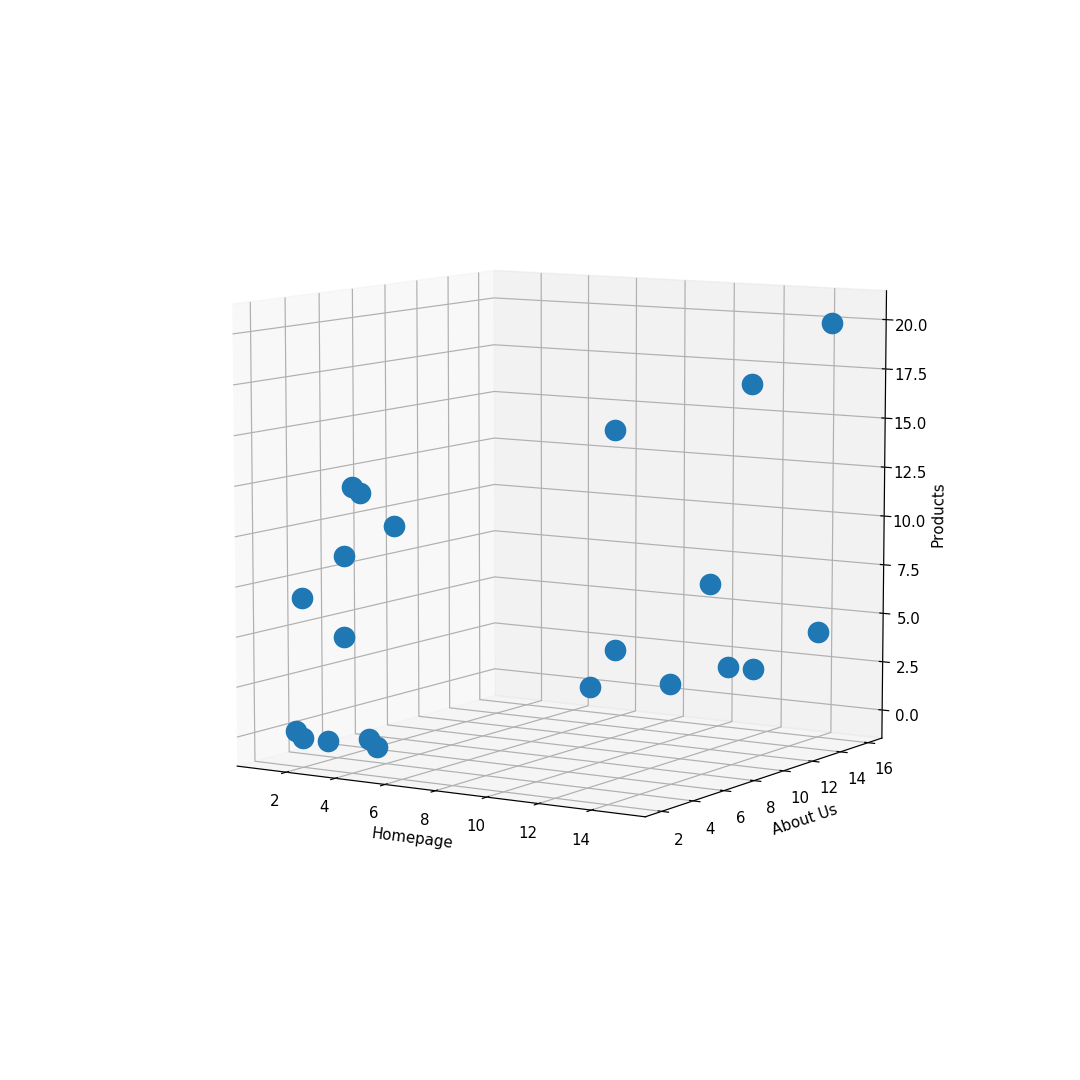

Text(0.5, 0, 'Products')

In [33]:
%matplotlib notebook

colormap = np.array(['yellow', 'red', 'blue','green','magenta'])

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(xs = visitors_df.homepage, 
           ys = visitors_df.about_us_page, 
           zs = visitors_df.products_page, 
           s= 180, 
           depthshade = False)
    
ax.set_xlabel('Homepage')
ax.set_ylabel('About Us')
ax.set_zlabel('Products')

<font color='#544640'>Click and drag the plot to rotate.

We'll create a dendrogram to analyze the way these visitors are similar, and how they break down into similar or dissimilar groups. This helps us to understand how many clusters we want to try to form, $k=1,2,3\ldots$.
</font>

<IPython.core.display.Javascript object>


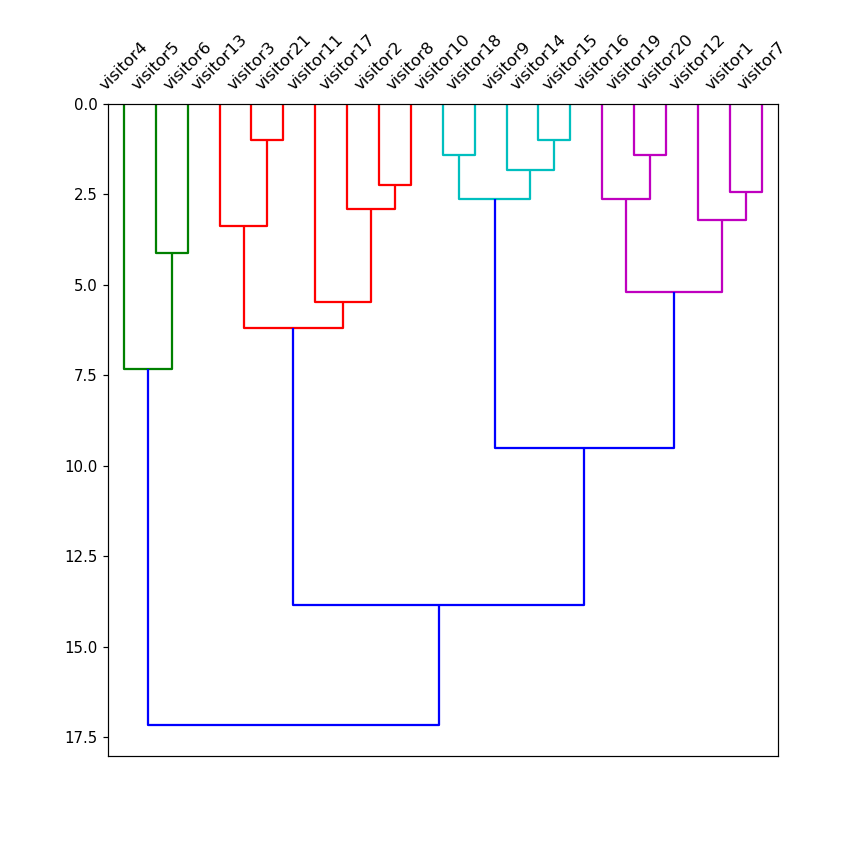

In [37]:
Z = linkage(visitors_df, 'average')
plt.figure(figsize=(8, 8))
D = dendrogram(
    Z=Z,
    orientation='bottom', 
    color_threshold=7.5,
    leaf_font_size=11, 
    labels = visitors_df.index)

<font color='#544640'>We will choose to go with $k=4$ clusters for our model. Once the data points are clustered, we'll replot the dataset with the points colored to represent the cluster they were found to exist in.</font>

In [38]:
k = 4
model = KMeans(n_clusters = k)
model.fit(visitors_df[['homepage','about_us_page','products_page']])
# print(model.labels_)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

<IPython.core.display.Javascript object>


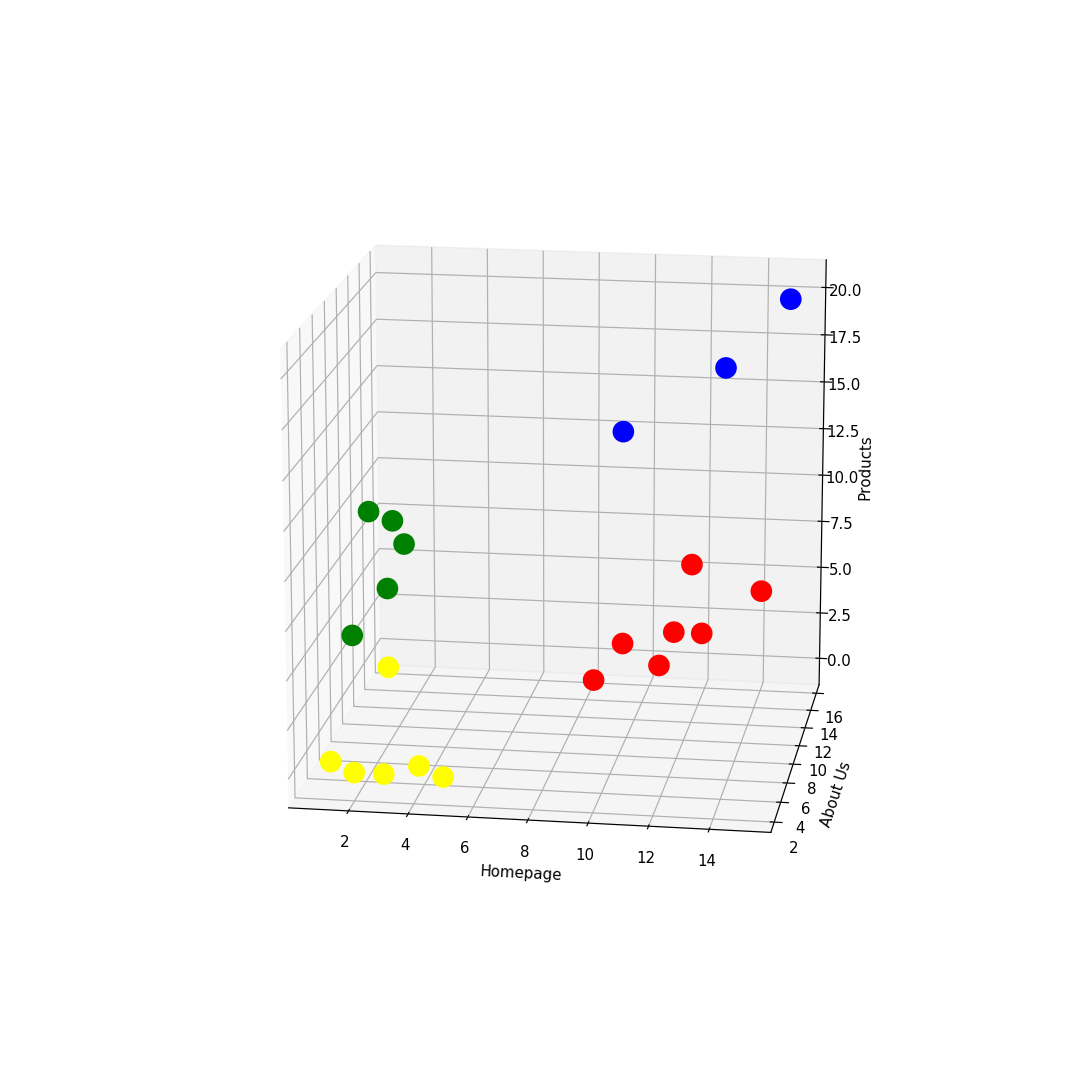

Text(0.5, 0, 'Products')

In [39]:
%matplotlib notebook

colormap = np.array(['yellow', 'red', 'blue','green','magenta'])

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(xs = visitors_df.homepage, 
           ys = visitors_df.about_us_page, 
           zs = visitors_df.products_page, 
           s= 180, 
           depthshade = False, 
           c = colormap[model.labels_])
    
ax.set_xlabel('Homepage')
ax.set_ylabel('About Us')
ax.set_zlabel('Products')

<font color='#544640'>Rotating the plot around will show you how we have clustered the users into four groups. The algorithm did a pretty good job. You can almost imagine a three-dimensional (but invisible) ***Voronoi diagram*** separating the points.

Now that we have this model built, we can use it to predict a future user given their usage information. Try it yourself.
</font>

Simulate a website user. Enter the user stats below..
  Hits on Homepage  [1 - 15]: 300
  Hits in About Us? [1 - 20]: 400
  Hits in Products  [1 - 20]: 200

The predicted category for this user data point is blue


<IPython.core.display.Javascript object>


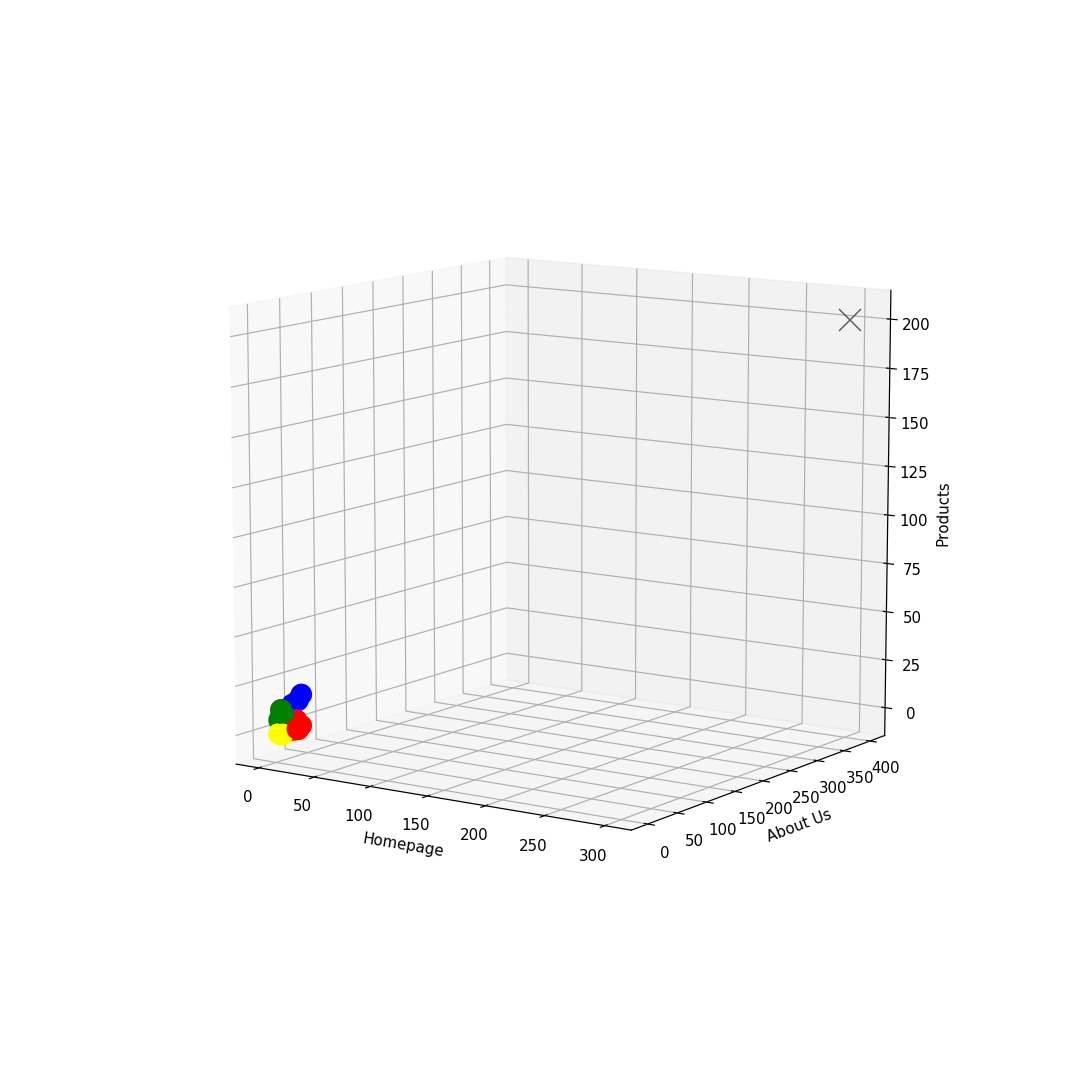

Text(0.5, 0, 'Products')

In [41]:
print('Simulate a website user. Enter the user stats below..')
try:
    homepage = float(input('  Hits on Homepage  [1 - 15]: '))
    about_us = float(input('  Hits in About Us? [1 - 20]: '))
    products = float(input('  Hits in Products  [1 - 20]: '))
except:
    print('Something went wrong.')
      
data_class = model.predict(np.array([homepage, about_us, products]).reshape(1, -1))[0]

print('\nThe predicted category for this user data point is ' + str(colormap[data_class]))

%matplotlib notebook

colormap = np.array(['yellow', 'red', 'blue','green','magenta'])

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(xs = visitors_df.homepage, 
           ys = visitors_df.about_us_page, 
           zs = visitors_df.products_page, 
           s= 180, 
           depthshade = False, 
           c = colormap[model.labels_])

ax.plot([homepage], [about_us], [products], markerfacecolor='k', markeredgecolor='k', marker='x', markersize=15, alpha=0.6)

ax.set_xlabel('Homepage')
ax.set_ylabel('About Us')
ax.set_zlabel('Products')

<font color='#544640'>What happens when you put a much larger number into the model for one of its inputs?</font>

<br><br><font color="#B81590">$$\large-\infty-$$</font><br><br>